# EDGAR Inventory Processing

This tutorial demonstrates how to process EDGAR inventory data.

We will perform the following steps:

* Load the data
* Create a grid for the output
* Remap the inventory to the grid
* Process the data
* Save the output


## EDGAR Files

In this section, we will examine the EDGAR NetCDF files.

These files can be downloaded directly from the [EDGAR website](https://edgar.jrc.ec.europa.eu/emissions_data_and_maps). However, the most convenient method is to use the `download_edgar_files` function provided by emiproc, as demonstrated below.


In [1]:
from pathlib import Path
from emiproc.inventories.edgar import download_edgar_files

local_dir = Path("./edgar")
local_dir.mkdir(exist_ok=True)

In [2]:
download_edgar_files(local_dir, year=2022, substances=["CH4", "CO2", "CO2bio"])

Downloaded 49 files.


Let's examine one of the downloaded files.


In [3]:
import xarray as xr


path_edgar_file = local_dir / "v8.0_FT2022_GHG_CH4_2022_ENE_emi.nc"

ds = xr.open_dataset(path_edgar_file)
ds

<xarray.Dataset> Size: 26MB
Dimensions:    (lat: 1800, lon: 3600)
Coordinates:
  * lat        (lat) float64 14kB -89.95 -89.85 -89.75 ... 89.75 89.85 89.95
  * lon        (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
Data variables:
    emissions  (lat, lon) float32 26MB ...
Attributes:
    institution:       European Commission, Joint Research Centre
    source:            https://edgar.jrc.ec.europa.eu/dataset_ghg80
    how_to_cite:       https://edgar.jrc.ec.europa.eu/dataset_ghg80#howtocite
    copyright_notice:  https://edgar.jrc.ec.europa.eu/dataset_ghg80#conditions
    contacts:          https://edgar.jrc.ec.europa.eu/dataset_ghg80#info JRC-...

Creating code to parse inventory files for every project can be cumbersome.

The goal of emiproc is to provide a straightforward interface for reading emissions inventories. In this case, you can use the `EDGARv8` class, which reads the EDGAR files and loads them as an `Inventory` object.


In [4]:
from emiproc.inventories.edgar import EDGARv8

# Load the edgar inventory
inv = EDGARv8(local_dir / "v8.0_*.nc")
inv

Inventory(EDGARv8)

## Visualizing the Inventory

Let's examine the contents of our inventory.

emiproc provides several functions to assist us in this process.


In [5]:
# We can look at the total emissions of the inventory (units are in kg/year)
inv.total_emissions.T

CO2bio           CO2  \
Agricultural waste burning                  1.311036e+12           NaN   
Power Industry                              7.798933e+11  1.466928e+13   
Combustion for manufacturing                2.000333e+12  6.537542e+12   
Fuel exploitation                           2.828933e+11  3.819373e+11   
Energy for buildings                        3.050478e+12  3.421570e+12   
Oil refineries and Transformation industry  5.612932e+10  2.149961e+12   
Solid waste incineration                    6.619834e+09  1.720349e+10   
Railways, pipelines, off-road transport     2.066671e+09  2.553750e+11   
Shipping                                    2.562250e+09  9.060895e+11   
Road transportation                         2.980679e+11  6.037368e+12   
__total__                                   7.790079e+12  3.852201e+13   
Agricultural soils                                   NaN  1.505788e+11   
Chemical processes                                   NaN  7.609800e+11   
Iron and steel production                            NaN  2.670123e+11   
Non energy use of fuels                              NaN  2.779255e+10   
Non-ferrous metals production                        NaN  1.228363e+11   
Non-metallic minerals production                     NaN  1.982623e+12   
Solvents and products use                            NaN  6.510489e+10   
Aviation climbing_and_descent                        NaN  2.880314e+11   
Aviation cruise                                      NaN  3.886084e+11   
Aviation landing_and_takeoff                         NaN  9.212053e+10   
Enteric fermentation                                 NaN           NaN   
Manure management                                    NaN           NaN   
Solid waste landfills                                NaN           NaN   
Waste water handling                                 NaN           NaN   

                                                     CH4  
Agricultural waste burning                  2.336499e+09  
Power Industry                              4.982441e+08  
Combustion for manufacturing                6.950362e+08  
Fuel exploitation                           1.167732e+11  
Energy for buildings                        1.133221e+10  
Oil refineries and Transformation industry  6.650997e+09  
Solid waste incineration                    1.708411e+09  
Railways, pipelines, off-road transport     8.751226e+06  
Shipping                                    8.333782e+07  
Road transportation                         9.613296e+08  
__total__                                   3.883260e+11  
Agricultural soils                          3.647085e+10  
Chemical processes                          3.591839e+08  
Iron and steel production                   1.596799e+08  
Non energy use of fuels                              NaN  
Non-ferrous metals production                        NaN  
Non-metallic minerals production                     NaN  
Solvents and products use                            NaN  
Aviation climbing_and_descent               2.016137e+06  
Aviation cruise                             2.720146e+06  
Aviation landing_and_takeoff                6.448174e+05  
Enteric fermentation                        1.122747e+11  
Manure management                           1.272364e+10  
Solid waste landfills                       3.844845e+10  
Waste water handling                        4.683614e+10

Plot the inventory using built-in functions.


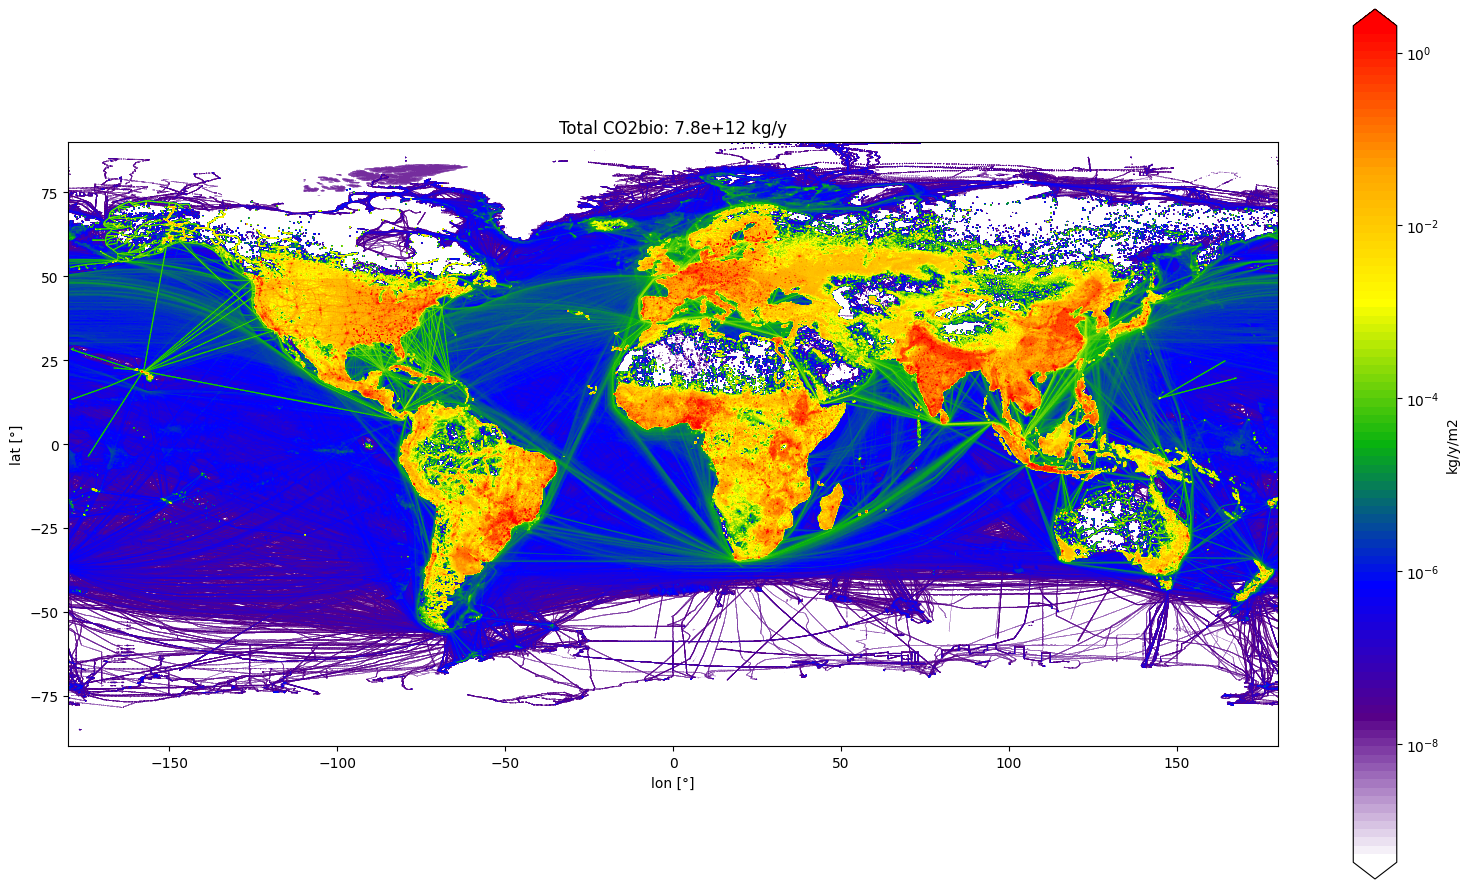

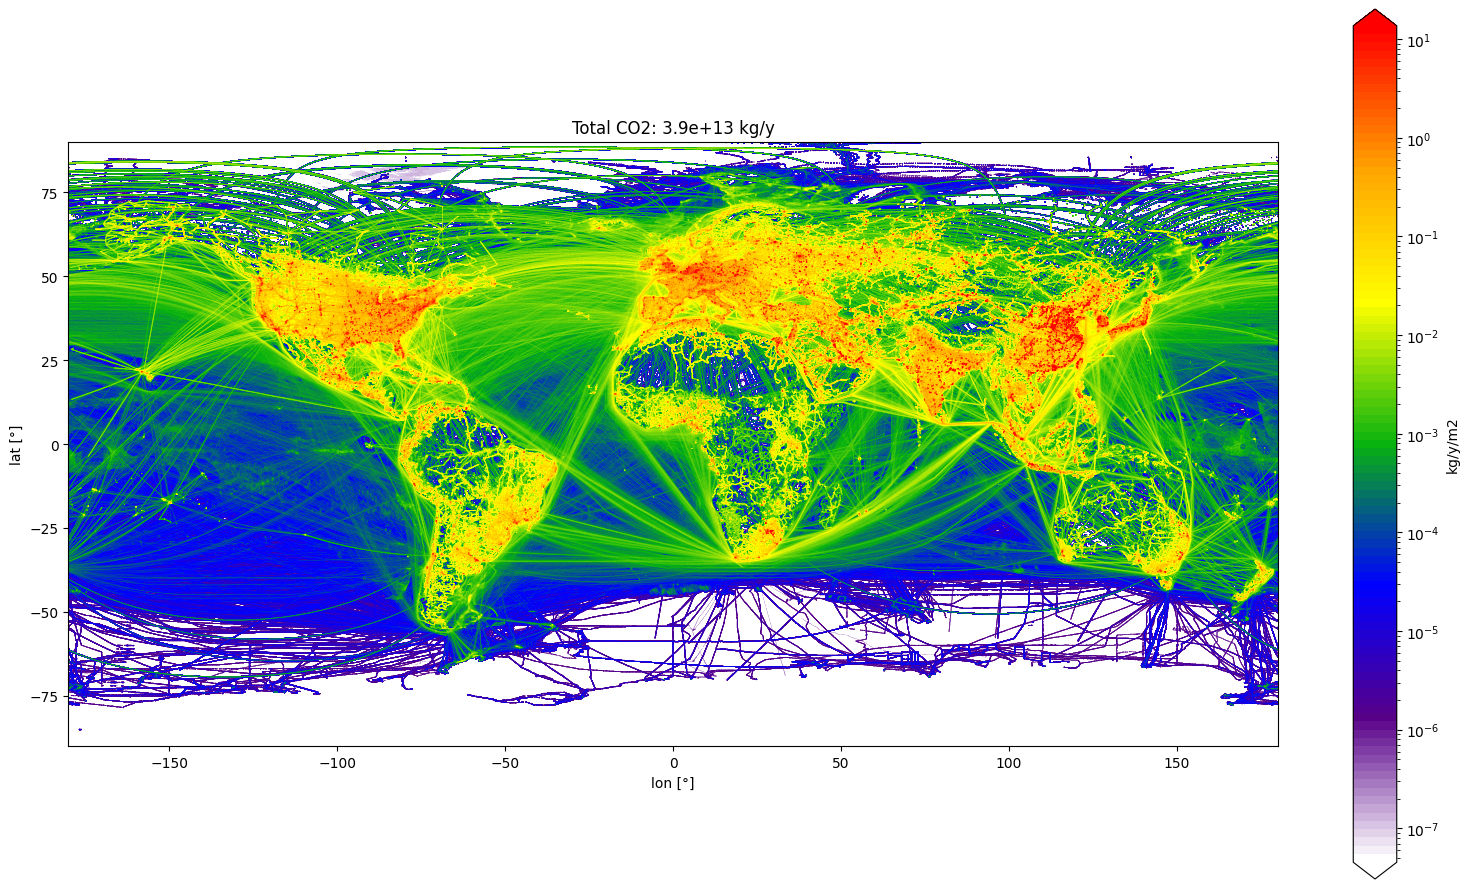

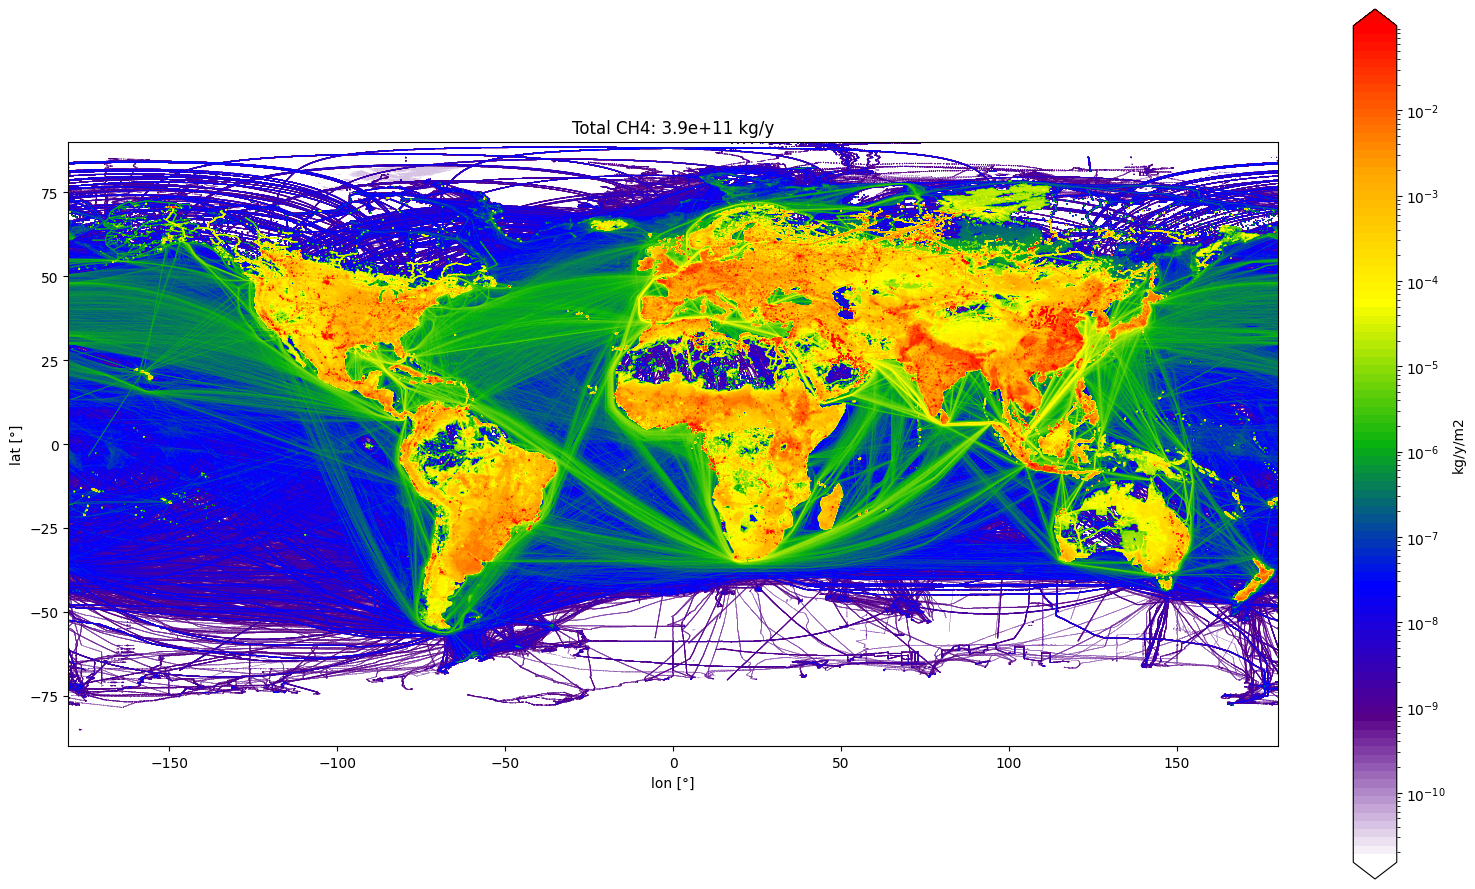

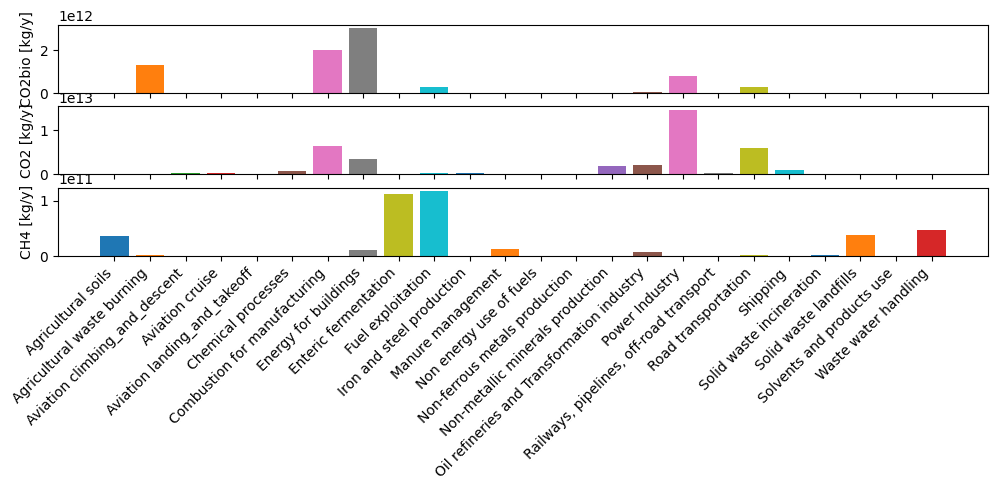

In [6]:
import matplotlib.pyplot as plt
from emiproc.plots import plot_inventory

plt.style.use("default")

plot_inventory(inv, total_only=True)

From these results, we can observe how emissions are distributed globally.

In the totals, the largest categories of methane emissions are
`Enteric fermentation` and `Fuel exploitation`. For CO2, the `Power Industry` is the largest category, followed by `Road Transportation`, `Combustion for manufacturing`, and `Energy for buildings`.

Most of these categories can be mitigated through the electrification of the economy and the adoption of renewable power sources. However, `Enteric fermentation`,  which refers to the emissions from cows and other ruminants digesting food, presents a unique challenge that can be relatively easier and faster to address by simply reducing or stopping meat consumption.

It is also important to note that many "natural" CO2 emissions are associated with meat production due to deforestation (not accounted for in EDGAR), making dietary changes a doubly beneficial approach.


## Processing the Inventory

In this step, we will demonstrate some standard operations that can be performed on the inventory.

### Remapping the Inventory

In this section, we will remap the inventory to a grid.

Suppose we want to perform a simulation over Australia. First, we need to create a custom grid.



In [7]:
from emiproc.grids import RegularGrid

# The grid can be defined by various parameters
# See the documentation for more details
# https://emiproc.readthedocs.io/en/master/api/grids.html#emiproc.grids.RegularGrid
australian_grid = RegularGrid(xmin=110, xmax=160, ymin=-45, ymax=-10, nx=200, ny=160)
australian_grid

RegularGrid(x(110,160)_y(-45,-10)_nx(200)_ny(160))

In some cases, you may already have a grid for your simulation, which you could import into emiproc with appropriate code.
A [tutorial for developper](
    https://emiproc.readthedocs.io/en/master/contrib/create_grid.html
)
 is available. 

In [8]:
# Remap the inventory on the grid
from emiproc.regrid import remap_inventory

remapped = remap_inventory(inv, australian_grid)
remapped

C:\Users\coli\Documents\emiproc\emiproc\regrid.py:251: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_weights.geometry_inter.area / gdf_weights.geometry.area


Inventory(Inventory)

Let's examine our remapped inventory.

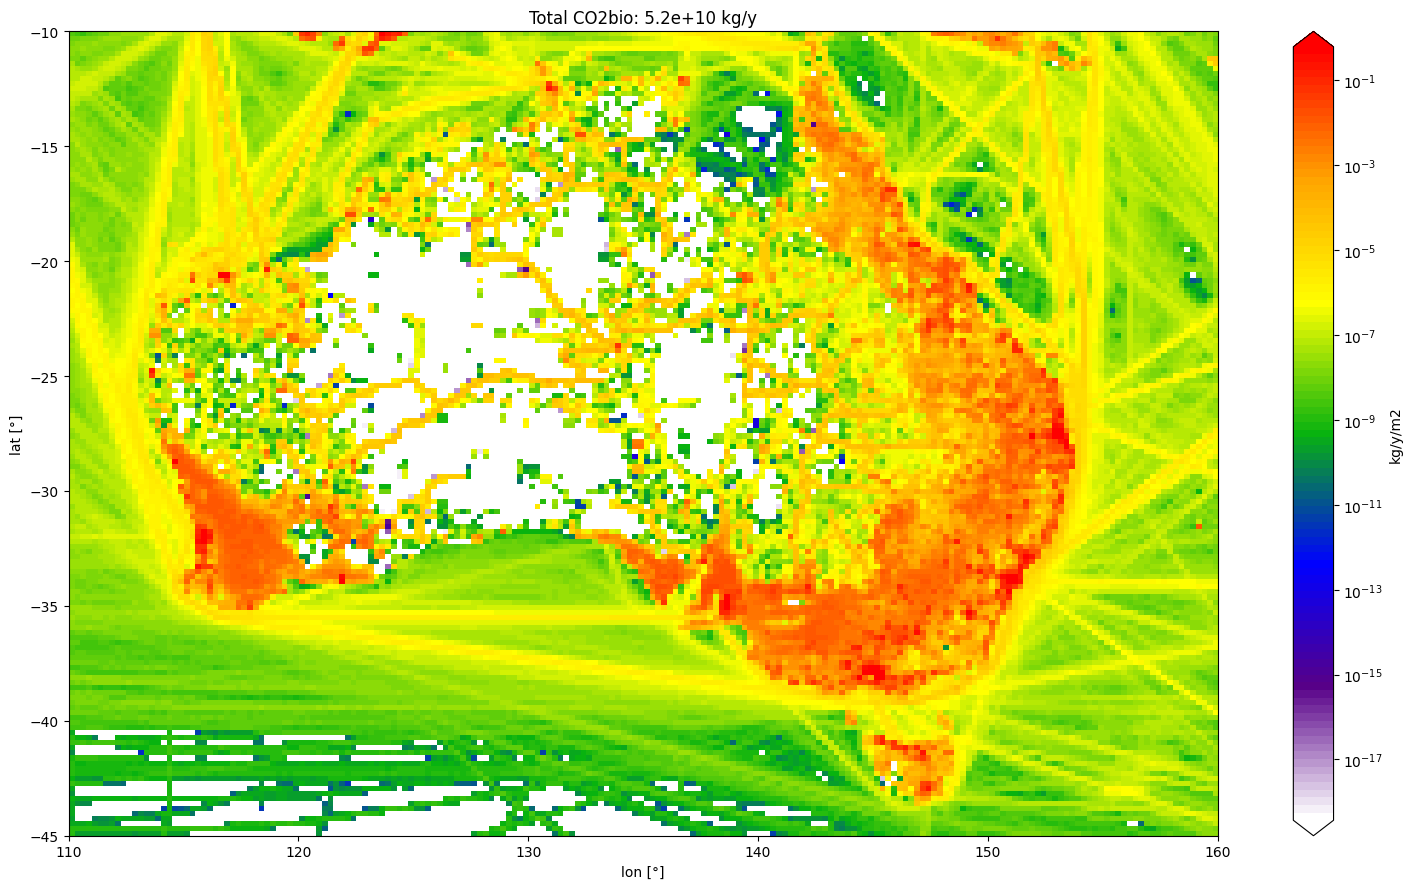

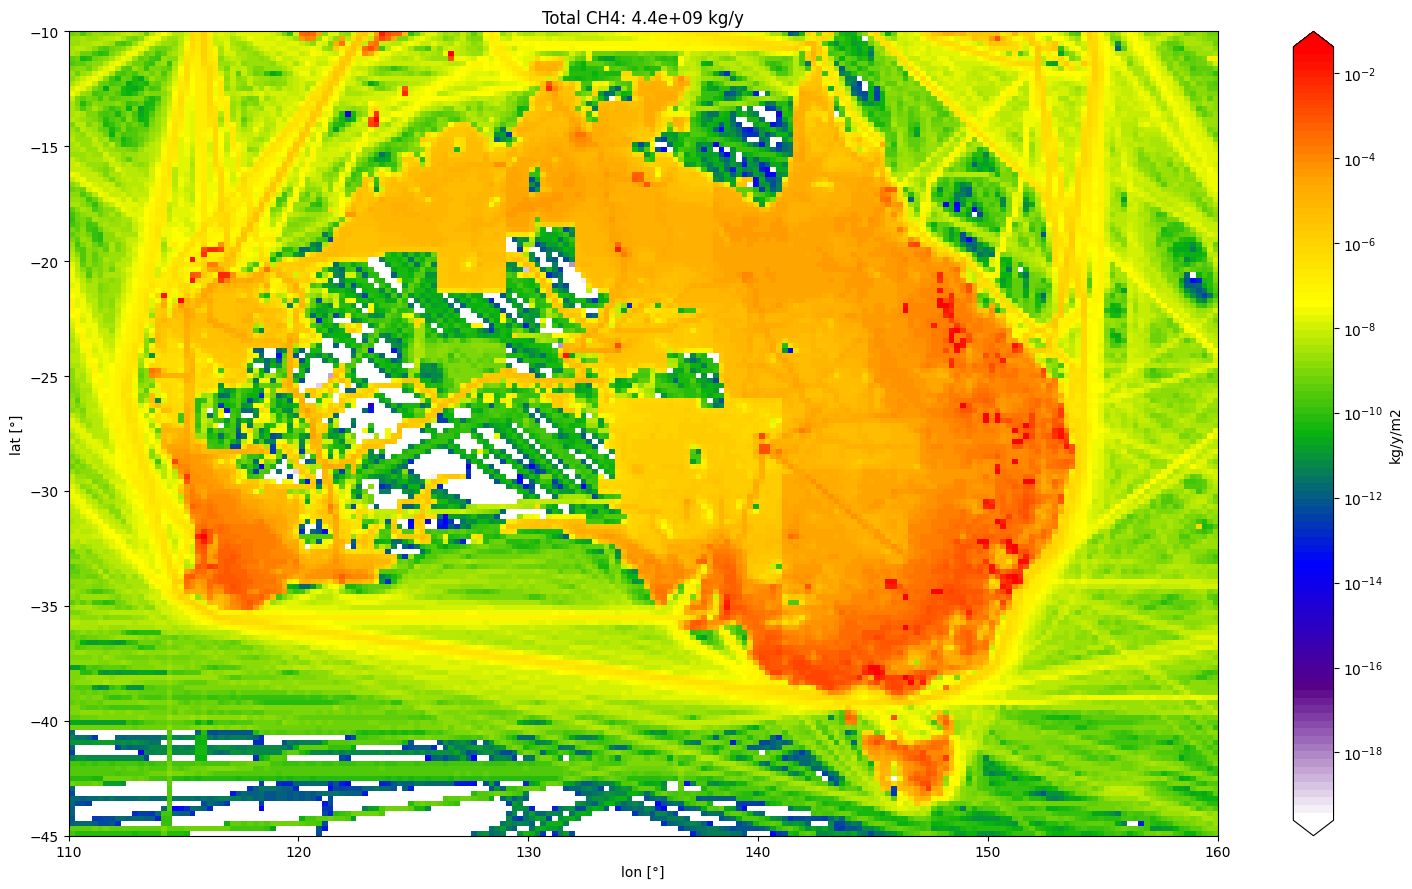

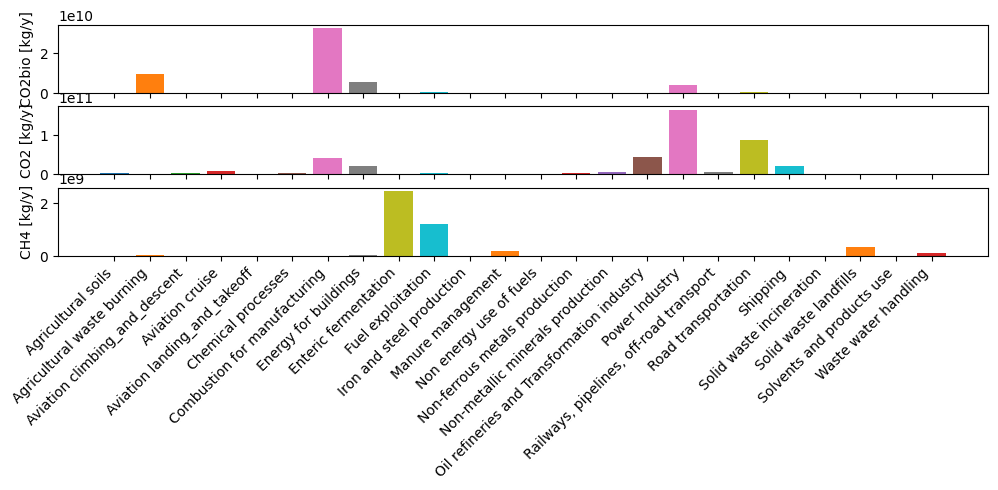

In [9]:
plot_inventory(remapped, total_only=True)

For this domain, the panorama is quite different.
For example, waste is well-managed in Australia, so its fraction of the total emissions is smaller.
Maybe Australia exports its waste to other regions such as Asia or Africa ? Who knows ?

### Grouping Categories

Many categories are similar and have very small emissions.

In such cases, we can group some categories together to reduce the number of emission sectors.

In [10]:
from emiproc.inventories.utils import group_categories

grouped = group_categories(
    remapped,
    categories_group={
        "agriculture": [
            "Agricultural soils",
            "Agricultural waste burning",
            "Manure management",
        ],
        "industry": [
            "Chemical processes",
            "Power Industry",
            "Oil refineries and Transformation industry",
            "Fuel exploitation",
            "Energy for buildings",
            "Combustion for manufacturing",
            "Iron and steel production",
            "Non energy use of fuels",
            "Solvents and products use",
            "Non-ferrous metals production",
            "Non-metallic minerals production",
        ],
        "livestock": ["Enteric fermentation"],
        "waste": [
            "Waste water handling",
            "Solid waste incineration",
            "Solid waste landfills",
        ],
        "transportation": [
            "Aviation climbing_and_descent",
            "Aviation cruise",
            "Aviation landing_and_takeoff",
            "Railways, pipelines, off-road transport",
            "Shipping",
            "Road transportation",
        ],
    },
)
grouped.total_emissions.T

CO2bio           CO2           CH4
agriculture     9.643720e+09  2.511675e+09  1.982405e+08
industry        4.213225e+10  2.890639e+11  1.234076e+09
transportation  6.677173e+08  1.276029e+11  9.711887e+06
__total__       5.244368e+10  4.191947e+11  4.363407e+09
waste                    NaN  1.624781e+07  4.603737e+08
livestock                NaN           NaN  2.461004e+09

### Merging CO2 Emissions

Ultimately, we aim to obtain the total CO2 emissions.

To achieve this, we will sum the biogenic CO2 with the fossil CO2 emissions.


In [11]:
from emiproc.speciation import merge_substances


merged = merge_substances(grouped, {"CO2": ["CO2", "CO2bio"]})
merged.total_emissions.T

CO2           CH4
agriculture     1.215540e+10  1.982405e+08
industry        3.311962e+11  1.234076e+09
waste           1.624781e+07  4.603737e+08
transportation  1.282706e+11  9.711887e+06
__total__       4.716384e+11  4.363407e+09
livestock                NaN  2.461004e+09

## Final Review

Before exporting the inventory, let's take a final look at the results.

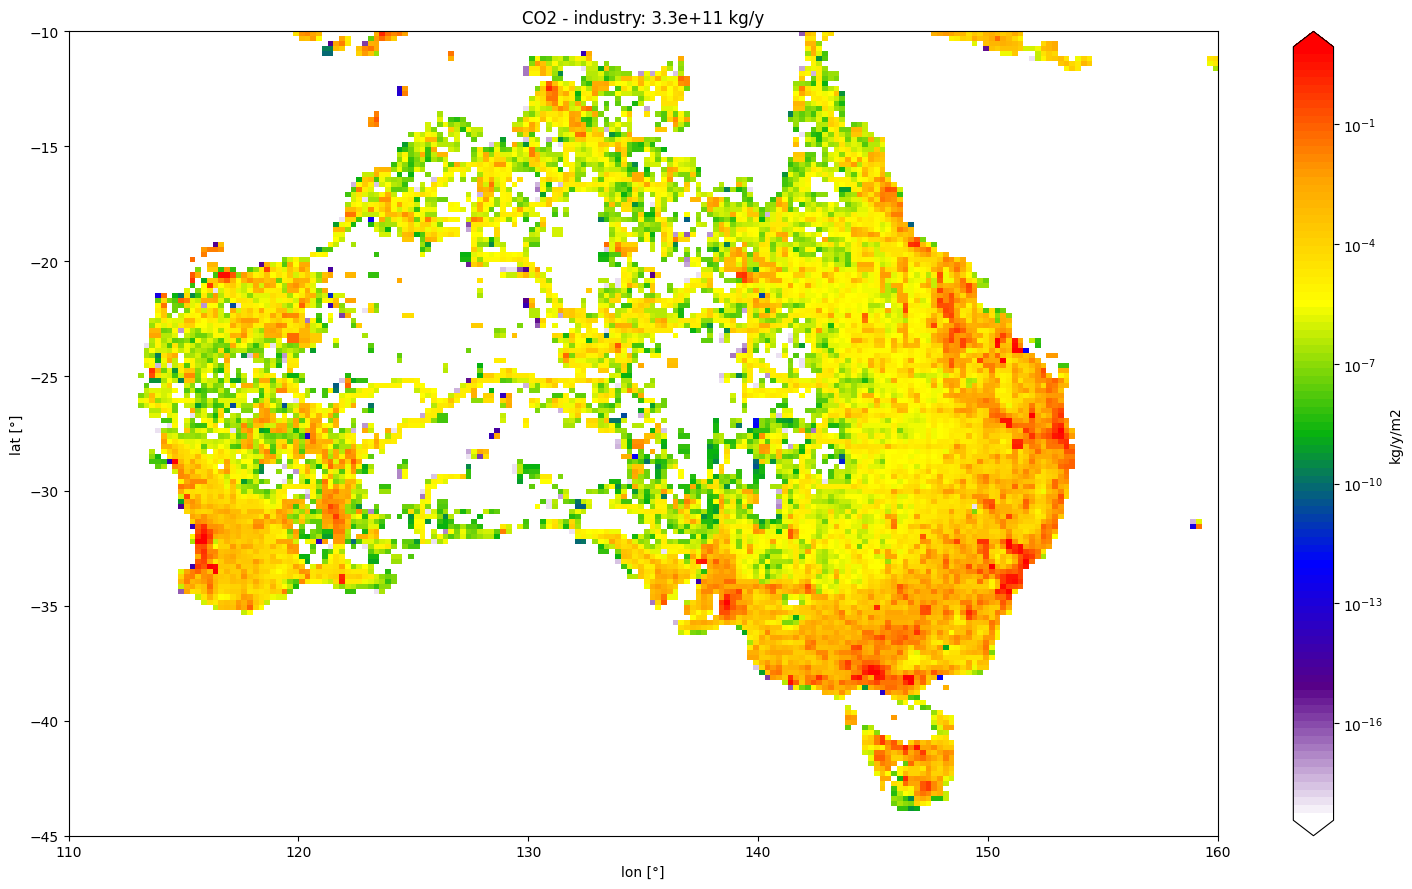

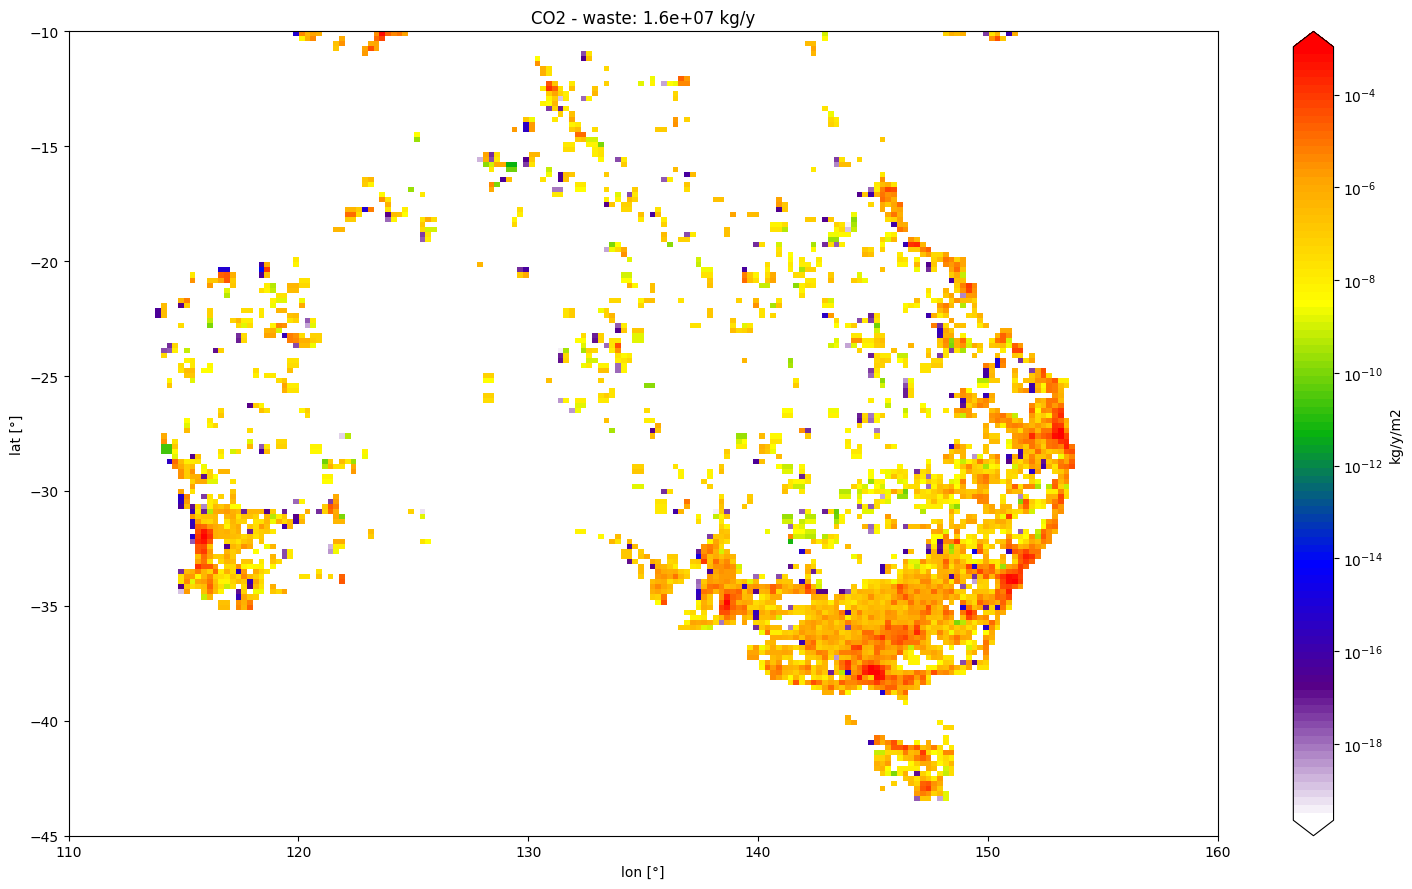

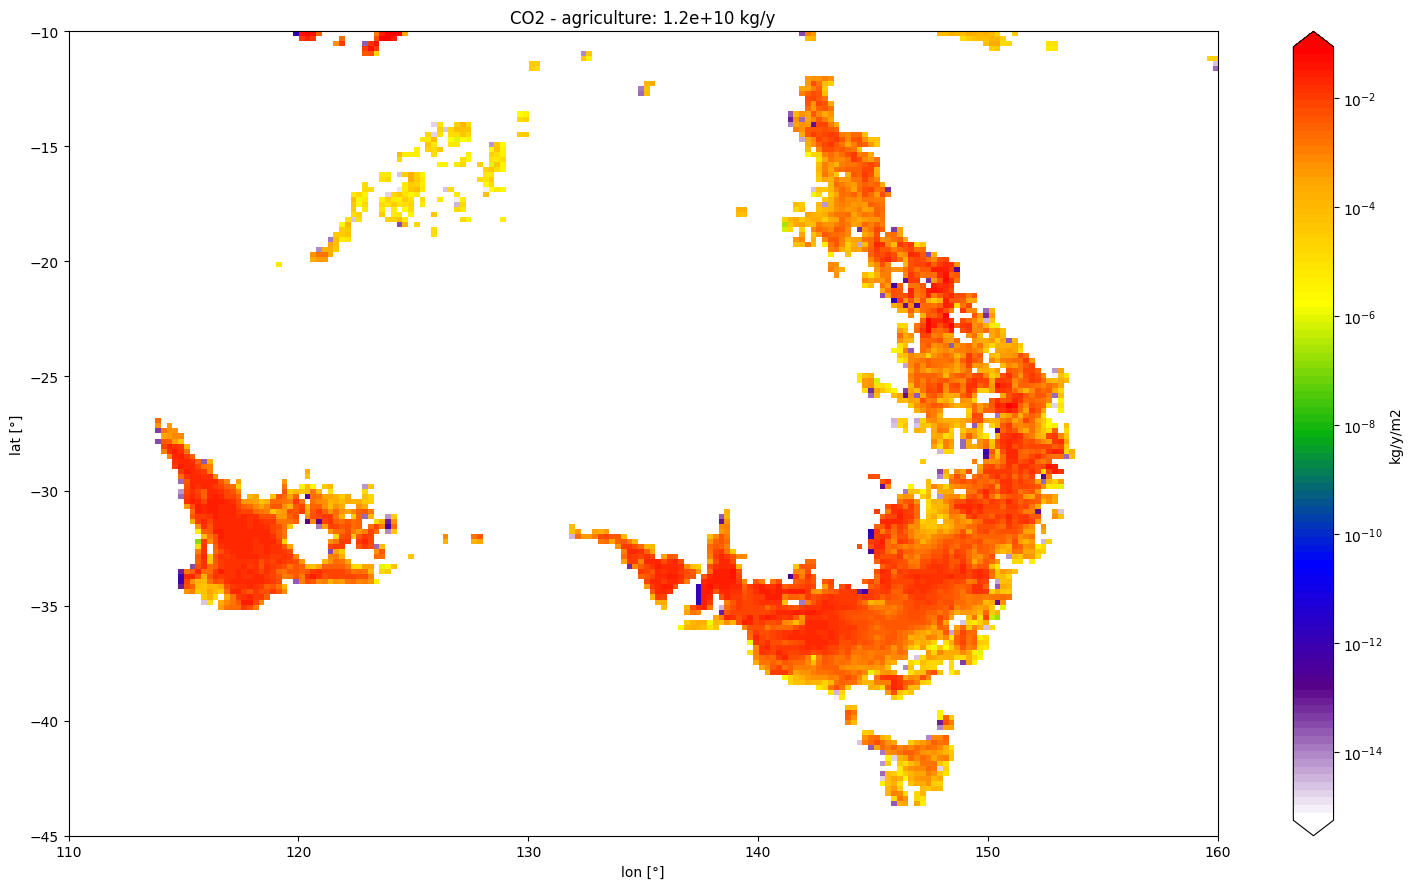

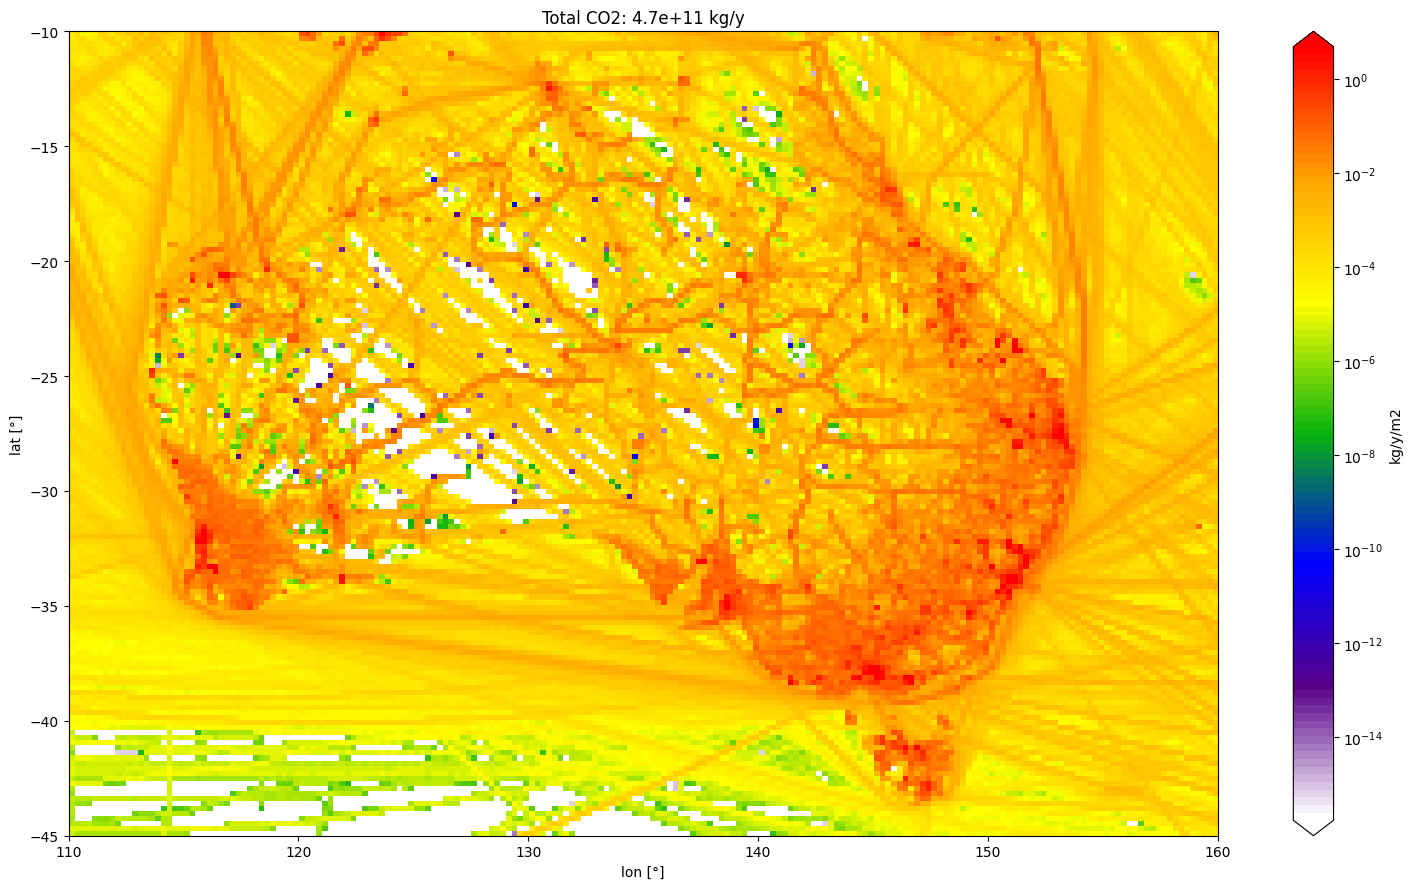

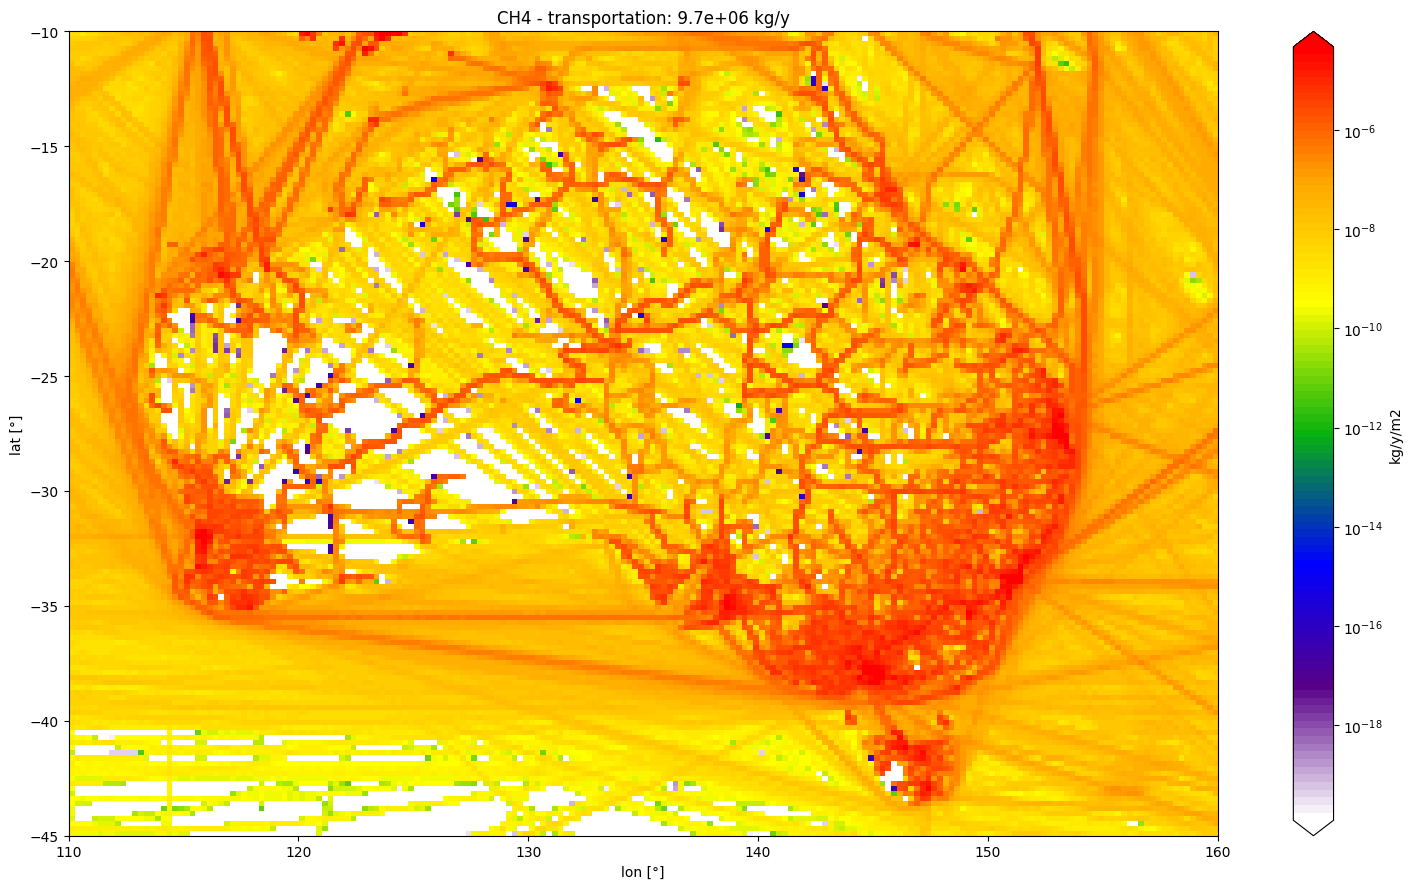

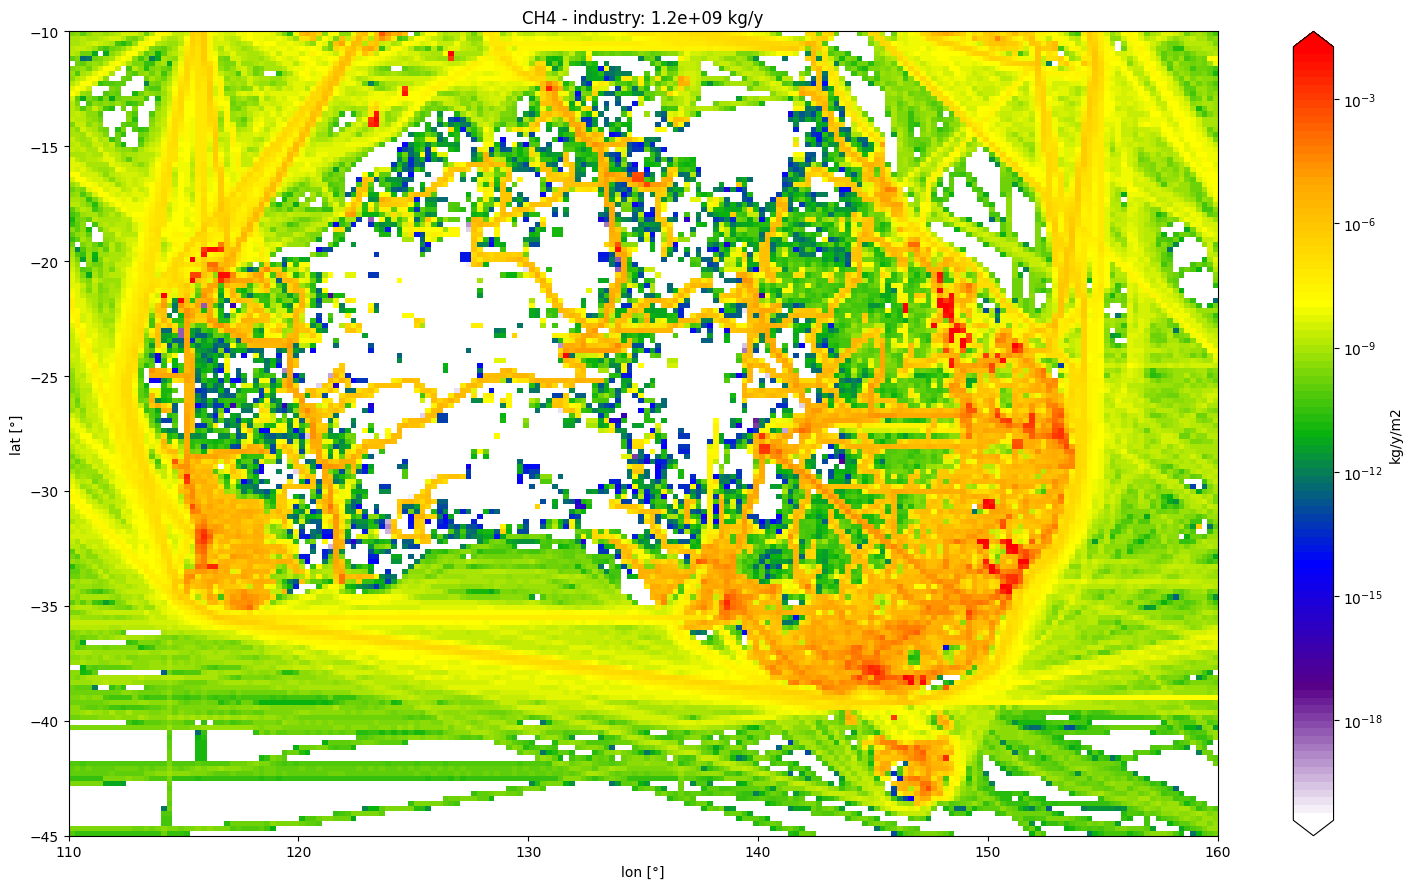

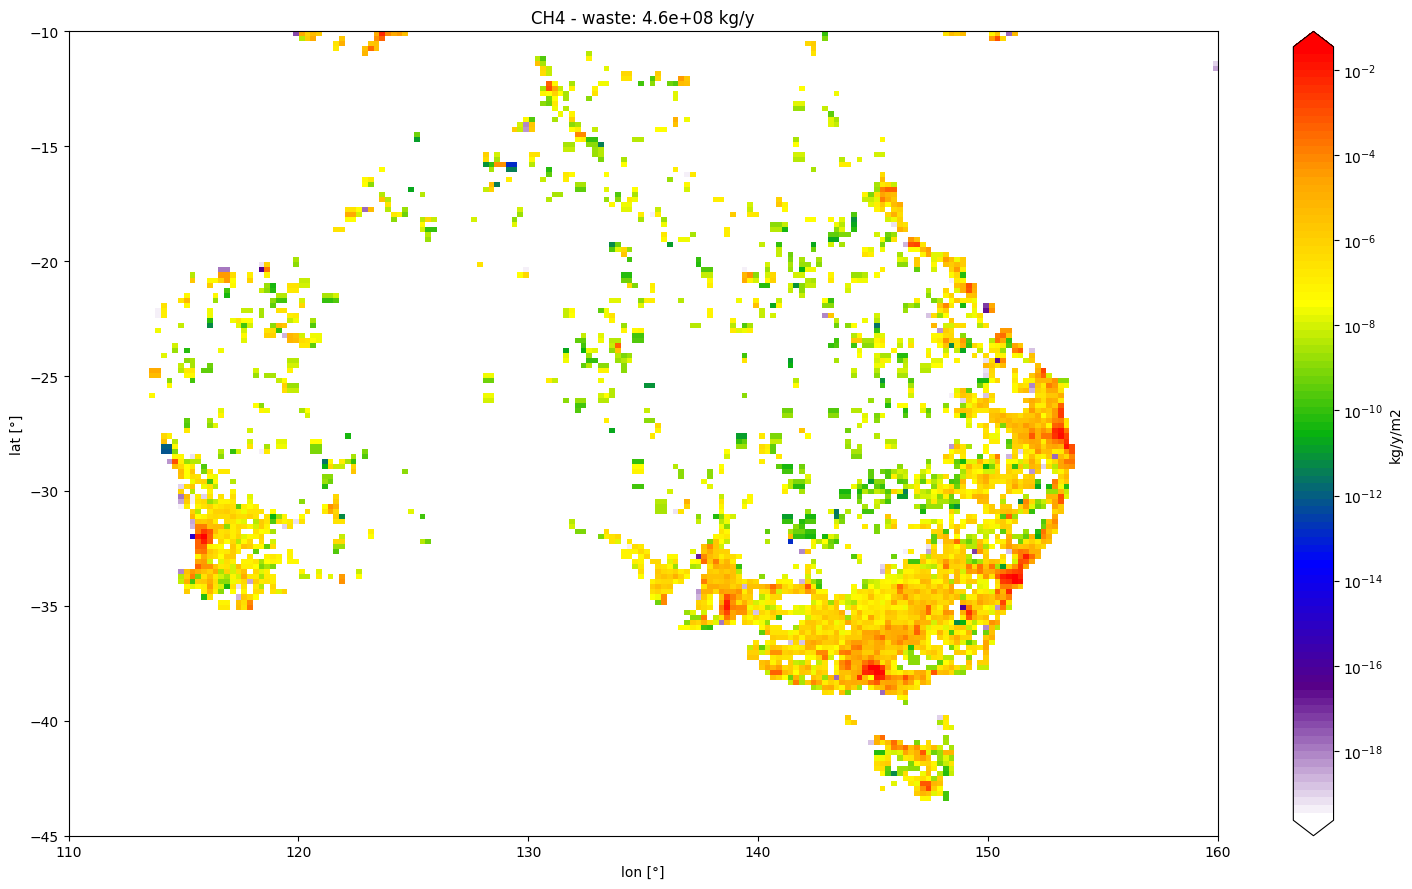

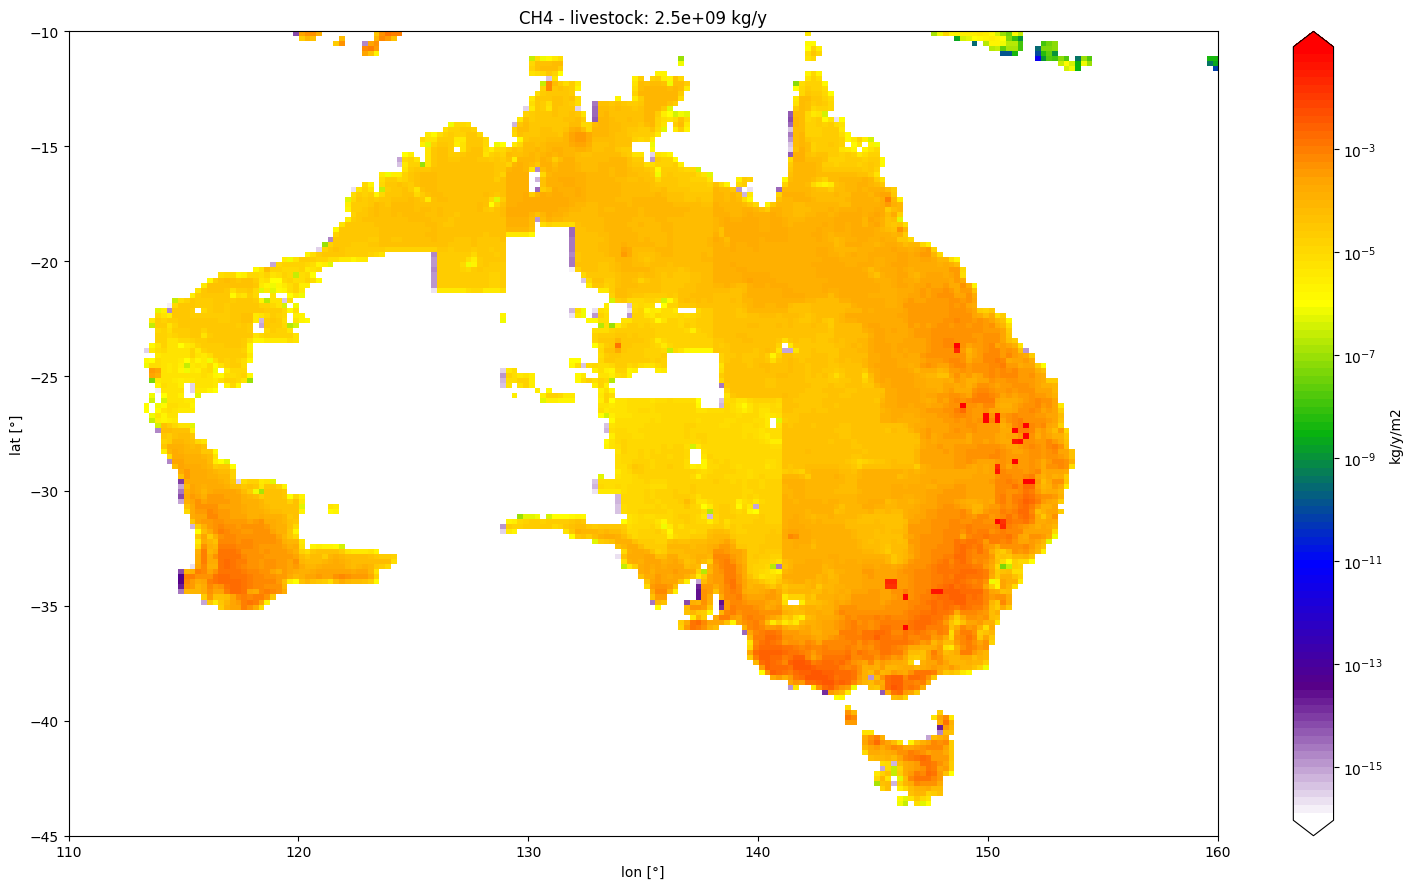

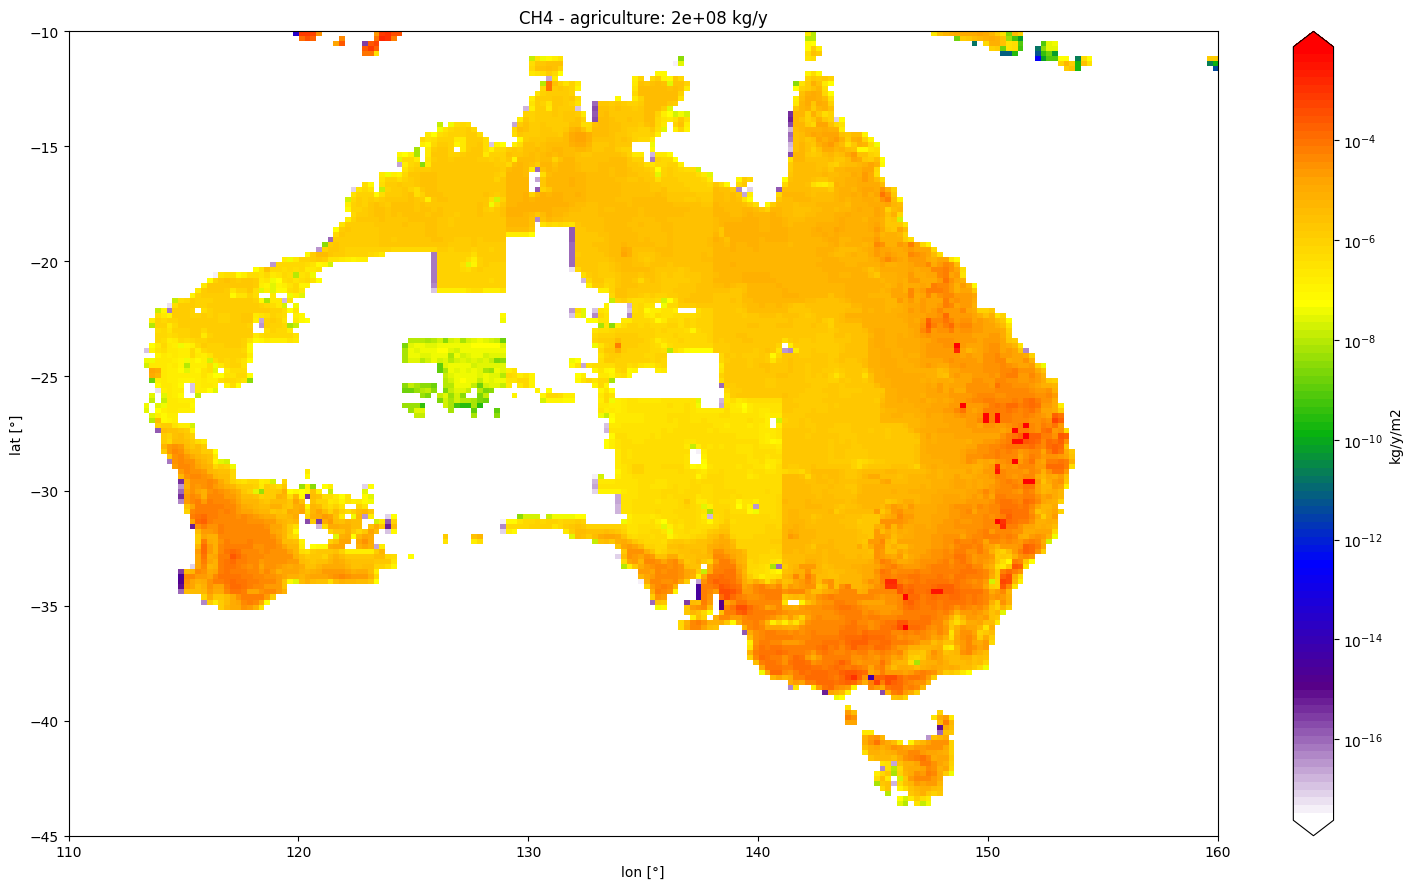

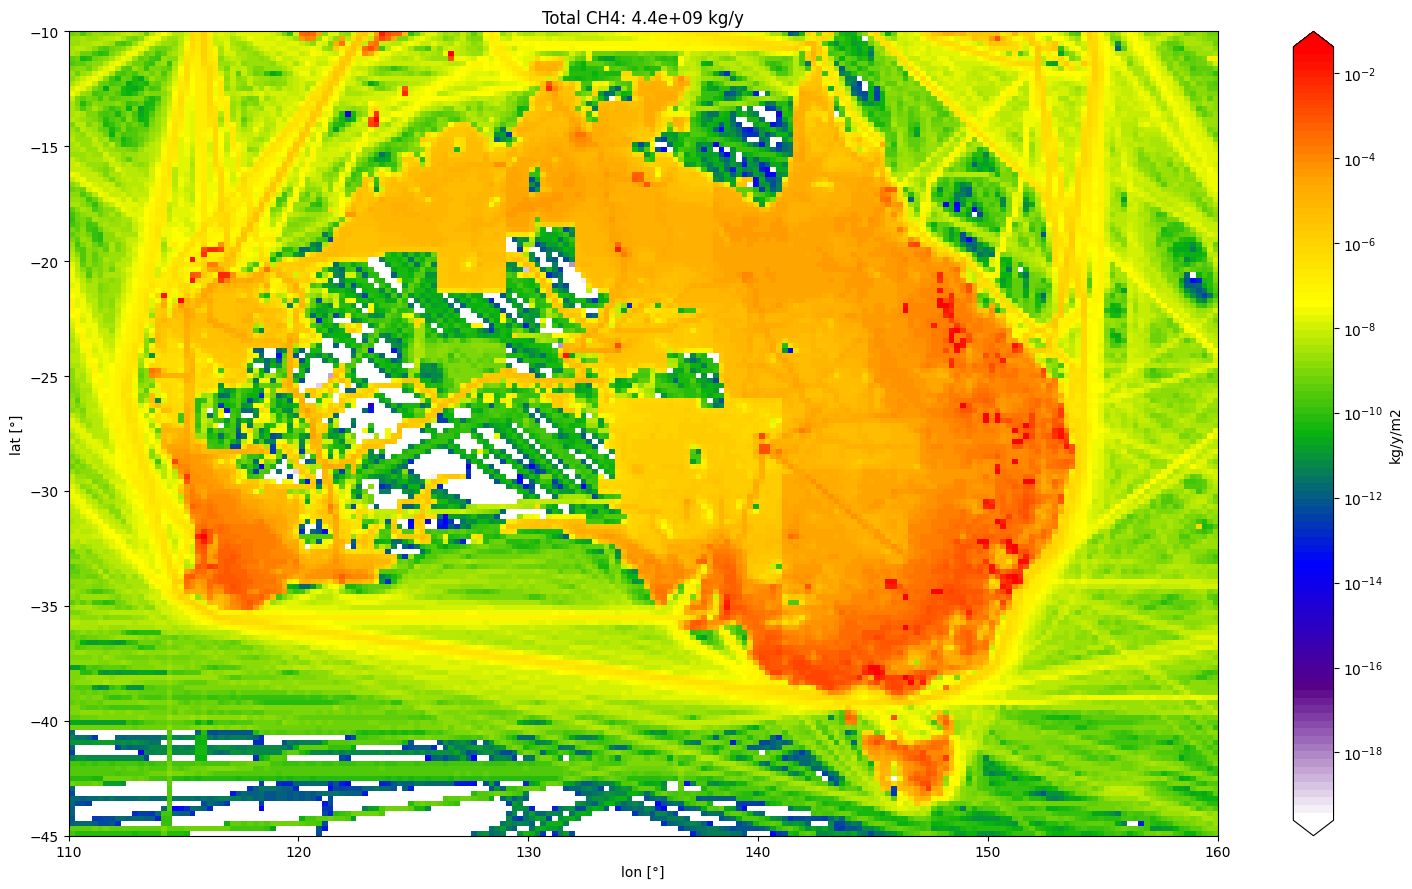

In [12]:
plot_inventory(merged)

## Exporting the Inventory

One of the main features of emiproc is its ability to export the inventory to various types of simulation inputs.

In this example, we will save the inventory to a NetCDF file.


In [13]:
from emiproc.exports.rasters import export_raster_netcdf

export_path = local_dir / "australia.nc"
export_raster_netcdf(merged, export_path)
print("Exported")

Exported


We can open the file with xarray to examine its contents.

In [14]:
ds = xr.load_dataset(export_path)
ds

<xarray.Dataset> Size: 3MB
Dimensions:              (lat: 160, lon: 200, substance: 2, category: 5,
                          lon_bnds: 201, lat_bnds: 161)
Coordinates:
  * substance            (substance) <U3 24B 'CO2' 'CH4'
  * category             (category) <U14 280B 'transportation' ... 'agriculture'
  * lon                  (lon) float64 2kB 110.1 110.4 110.6 ... 159.6 159.9
  * lat                  (lat) float64 1kB -44.89 -44.67 ... -10.33 -10.11
  * lon_bnds             (lon_bnds) float64 2kB 110.0 110.2 ... 159.8 160.0
  * lat_bnds             (lat_bnds) float64 1kB -45.0 -44.78 ... -10.22 -10.0
Data variables: (12/14)
    CO2_transportation   (lat, lon) float64 256kB 3.459e+03 962.6 ... 2.149e+06
    CO2_industry         (lat, lon) float64 256kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CO2_waste            (lat, lon) float64 256kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CO2_agriculture      (lat, lon) float64 256kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CH4_transportation   (lat, lon) float64 256kB 0.3154 0.08777 ... 10.4 18.34
    CH4_industry         (lat, lon) float64 256kB 5.127 2.634 ... 11.41 4.298
    ...                   ...
    CH4_agriculture      (lat, lon) float64 256kB 0.0 0.0 0.0 ... 0.0 0.0 0.0
    emi_CO2_all_sectors  (lat, lon) float64 256kB 3.459e+03 962.6 ... 2.149e+06
    emi_CO2_total        (category) float64 40B 1.283e+11 ... 1.216e+10
    emi_CH4_all_sectors  (lat, lon) float64 256kB 5.443 2.722 ... 21.81 22.64
    emi_CH4_total        (category) float64 40B 9.712e+06 ... 1.982e+08
    cell_area            (lat, lon) float64 256kB 4.801e+08 ... 6.63e+08
Attributes:
    Conventions:      CF-1.10
    title:            emiproc generated file
    comment:          
    source:           
    history:          2024-12-04 15:34:58: created by emiproc ;\n
    references:       Produced by emiproc.
    institution:      Empa, Swiss Federal Laboratories for Materials Science ...
    author:           emiproc
    contact:          https://emiproc.readthedocs.io/en/master/support.html#c...
    creation_time:    2024-12-04 15:34:58
    emiproc_history:  ["Inventory(EDGARv8) created as type:'EDGARv8'", 'Copie...

Plot with xarray to check the data



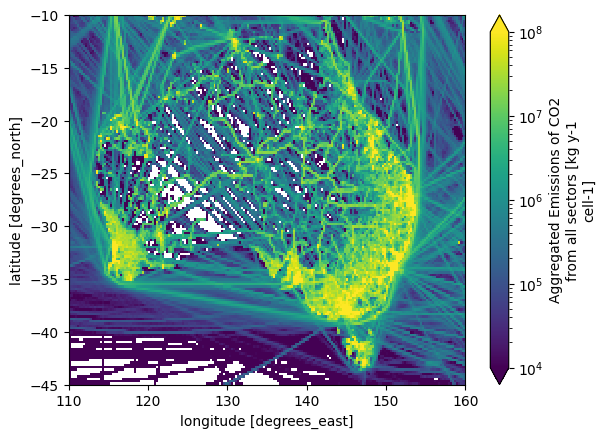

In [15]:
from matplotlib.colors import LogNorm


ds["emi_CO2_all_sectors"].plot(
    # use a logarithmic color scale, otherwise we only see the highest point sources.
    norm=LogNorm(vmin=1e4, vmax=1e8),
    cmap="viridis",
)

Indeed, the plots generated using emiproc were more refined and visually appealing (even though art is subjective).

## Conclusion

In this tutorial, we demonstrated how to process an emissions inventory using emiproc.

Depending on your needs, you may need to use different functions, inventories, and export options.

If you have any questions, please refer to our [support page](https://emiproc.readthedocs.io/en/master/support.html#support).